In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
import scipy.stats
import math

In [90]:
from pyfasta import Fasta
import tqdm
import seaborn as sns

In [4]:
def getNames(fastafile):
    f = Fasta(fastafile)
    return f.keys()

In [6]:
def constructGroundTruth(truelist,seq_names):
    count_tsv={}
    for name in seq_names:
        count_tsv[name] = 0
    with open(truelist) as fp:
        lines = fp.readlines()
        for line in lines:
            tr = line.strip().split("/")[-1]
            count_tsv[tr] += 1
    return count_tsv

In [5]:
seq_names = getNames("/mnt/scratch1/bleed_through_human/ref/transcript_clean_200K.fa")


In [59]:
def batchWriteTruth(types):
    for t in tqdm.tqdm(types):
        truth_list = "/".join(["/mnt/scratch1/bleed_through_human/poly_reads",t,"truth.list"])
        count_tsv = constructGroundTruth(truth_list, \
                                         seq_names)
        ground_df = pd.DataFrame(list(count_tsv.items()))
        ground_df.columns = ['transcript_id','expected_count']
        ground_df.to_csv("/".join(["/mnt/scratch1/bleed_through_human/poly_reads/quant",t,"truth.tsv"]), \
                         sep="\t",index=False)

In [ ]:
ground_df = pd.read_table("")

In [47]:
#ground_df.to_csv("/mnt/scratch1/bleed_through_human/poly_reads/quant/reads_101/truth.tsv",sep="\t",index=False)

In [178]:
##samplenames
types = []
import glob
fastq_files=glob.glob("/mnt/scratch1/bleed_through_human/poly_reads/*/*1.fasta.gz")
for f in fastq_files:
    dirname = f.split("/")[-2]
    types.append(dirname)

In [60]:
batchWriteTruth(types)

100%|██████████| 14/14 [07:14<00:00, 31.52s/it]


In [165]:
def getMergedDataFrameFast(typeof,files):
    truth = pd.read_table(files[typeof]["truth"], delim_whitespace=True, \
       usecols=["transcript_id", "count"])
    df = truth
    df.rename(index=str, \
            columns={"transcript_id": "Name", "count": "count"}, inplace = True)
    
    sla = pd.read_table(files[typeof]["SLA"], delim_whitespace=True, \
                                 usecols=["Name", "NumReads"])
    df = pd.merge(df,sla, how="outer", on = "Name").fillna(0.0)
    
    
    #bowtie = pd.read_table(files[typeof]["bowtie"], delim_whitespace=True, \
     #                            usecols=["Name", "NumReads"])
    #bowtie.rename(index=str, columns = {"Name" : "Name", \
     #                                   "NumReads": "NumReads_BT"}, inplace = True)
    
    #df = pd.merge(df,bowtie, how="outer", on = "Name").fillna(0.0)
    
    kallisto = pd.read_table(files[typeof]["kallisto"], delim_whitespace=True, \
                                     usecols=["target_id", "est_counts"])
    kallisto.rename(index=str, columns={"target_id": "Name", \
                                                "est_counts": "NumReads_KAL"}, inplace = True)
    df = pd.merge(df,kallisto, how="outer", on = "Name").fillna(0.0)
    
    hera = pd.read_table(files[typeof]["hera"], delim_whitespace=True, \
                                     usecols=["#target_id", "est_counts"])
    hera["#target_id"]= hera["#target_id"].str.split(":",expand=True)[0]
    hera.rename(index=str, columns={"#target_id": "Name", \
                                               "est_counts": "NumReads_hera"}, inplace = True)
    
    df = pd.merge(df,hera, how="outer", on = "Name").fillna(0.0)
    
    
    hera_mod = pd.read_table(files[typeof]["hera_mod"], delim_whitespace=True, \
                                     usecols=["#target_id", "est_counts"])
    hera_mod["#target_id"]= hera_mod["#target_id"].str.split(":",expand=True)[0]
    hera_mod.rename(index=str, columns={"#target_id": "Name", \
                                               "est_counts": "NumReads_hera_mod"}, inplace = True)
    
    df = pd.merge(df,hera_mod, how="outer", on = "Name").fillna(0.0)
    return (df,truth,sla,kallisto,hera)

In [151]:
def mergeHeraKallisto(typeof,files):
    
    #truth
    truth = pd.read_table(files[typeof]["truth"], delim_whitespace=True, \
       usecols=["transcript_id", "count"])
    df = truth
    df.rename(index=str, \
            columns={"transcript_id": "Name", "count": "count"}, inplace = True)
    
    #SLA
    sla = pd.read_table(files[typeof]["SLA"], delim_whitespace=True, \
                                 usecols=["Name", "NumReads"])
    df = pd.merge(df,sla, how="outer", on = "Name").fillna(0.0)
    
    #hera
    hera = pd.read_table(files[typeof]["hera"], delim_whitespace=True, \
                                     usecols=["#target_id", "est_counts"])
    hera["#target_id"]= hera["#target_id"].str.split(":",expand=True)[0]
    hera.rename(index=str, columns={"#target_id": "Name", \
                                               "est_counts": "NumReads_hera"}, inplace = True)
    df = pd.merge(df,hera, how="outer", on = "Name").fillna(0.0)
    
    #kallisto
    kallisto = pd.read_table(files[typeof]["kallisto"], delim_whitespace=True, \
                                     usecols=["target_id", "est_counts"])
    kallisto.rename(index=str, columns={"target_id": "Name", \
                                                "est_counts": "NumReads_KAL"}, inplace = True)
    df = pd.merge(df,kallisto, how="outer", on = "Name").fillna(0.0)
    
    return df

In [213]:
def relDiff(c1, c2, DF, cutoff=0.01, verbose=False):
    import pandas as pd
    """
    Computes the relative difference between the values
    in columns c1 and c2 of DF.
    c1 and c2 are column names and DF is a Pandas data frame.
    Values less than cutoff will be treated as 0.
    The relative difference is defined as
    d(x_i, y_i) =
        0.0 if x_i and y_i are 0
        (x_i - y_i) / (0.5 * |x_i - y_i|) otherwise
    This function returns two values.
    rd is a DataFrame where the "relDiff" column contains all
    of the computed relative differences.
    nz is a set of indexes into rd for data points where
    x_i and y_i were not *both* zero.
    """
    import numpy as np
    rd = pd.DataFrame(data = {"Name" : DF.index, "relDiff" : np.zeros(len(DF.index))*np.nan})
    rd.set_index("Name", inplace=True)
    bothZero = DF.loc[(DF[c1] <= cutoff) & (DF[c2] <= cutoff)].index
    nonZero = DF.index.difference(bothZero)
    if (verbose):
        print("Zero occurs in both columns {} times".format(len(rd.loc[bothZero])))
        print("Nonzero occurs in at least 1 column {} times".format(len(rd.loc[nonZero])))
    allRD = 1.0 * ((DF[c1] - DF[c2]) / (DF[c1] + DF[c2]).abs())
    assert(len(rd.loc[nonZero]["relDiff"]) == len(allRD[nonZero]))
    rd["relDiff"][nonZero] = allRD[nonZero]
    if len(bothZero) > 0:
        rd["relDiff"][bothZero] = 0.0
    return rd, nonZero

In [133]:
types_n = ["reads_101","reads_121","reads_114","reads_131","reads_120","reads_137"]

In [174]:
prefix = "/mnt/scratch1/bleed_through_human/poly_reads/quant"
#types = ["reads_101"]
files = {}
for t in types_n:
    fileinfo = {}
    fileinfo["truth"]= "/".join([prefix,t,"truth.tsv"])
    fileinfo["SLA"] =  "/".join([prefix,t,"salmon_out","quant.sf"])
    fileinfo["kallisto"] = "/".join([prefix,t,"kallisto_out","abundance.tsv"])
    fileinfo["bowtie"] = "/".join([prefix,t,"bowtie_out","quant.sf"])
    fileinfo["hera"] = "/".join([prefix,t,"hera_out","abundance.tsv"])
    fileinfo["hera_mod"] = "/".join(["/home/rob/our_hera/hera-master",t,"abundance.tsv"])
    files[t] = fileinfo

In [176]:
result_df = pd.DataFrame(columns=['sample','kallisto', 'SLA', 'hera','BT','hera_mod'])
for i,t in enumerate(types_n):
    df, truth, sla,kallisto,hera = getMergedDataFrameFast(t,files)
    kal=df["count"].corr(df["NumReads_KAL"],method="spearman")
    sla=df["count"].corr(df["NumReads"],method="spearman")
    hera=df["count"].corr(df["NumReads_hera"],method="spearman")
    #bt=df["count"].corr(df["NumReads_BT"],method="spearman")
    hera_mod=df["count"].corr(df["NumReads_hera_mod"],method="spearman")
    result_df.loc[i] = [t,kal,sla,hera,bt,hera_mod]
    #print("sample name: {}".format(t))
    #print("kallisto",df["count"].corr(df["NumReads_KAL"],method="spearman"))
    #print("SLA",df["count"].corr(df["NumReads"],method="spearman"))
    #print("BowTie2",df_30["count"].corr(df_30["NumReads_BT"],method="spearman"))
    #print("hera",df["count"].corr(df["NumReads_hera"],method="spearman"))

In [163]:
result_df.set_index(['sample'],inplace=True)

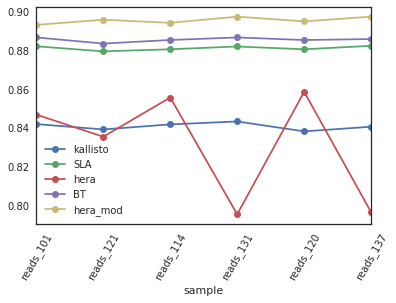

In [164]:
sns.set_style("white")
fig = plt.figure()
ax = fig.add_subplot(111)
result_df.plot(marker='o',rot=60,ax=ax)
#ax.set_xticks(result_df.index)

In [180]:
prefix = "/mnt/scratch1/bleed_through_human/poly_reads/quant"
#types = ["reads_101"]
files_rsem = {}
for t in types:
    fileinfo = {}
    #fileinfo["truth"]= "/mnt/scratch1/bleed_through_human/bleed_through_200K/rsem_exp/model.isoforms.results"
    fileinfo["truth"]= "/".join([prefix,t,"truth.tsv"])
    fileinfo["SLA"] =  "/".join([prefix,t,"salmon_out","quant.sf"])
    fileinfo["kallisto"] = "/".join([prefix,t,"kallisto_out","abundance.tsv"])
    #fileinfo["bowtie"] = "/".join([prefix,t,"quant","bowtie_out","quant.sf"])
    fileinfo["hera_mod"] = "/".join(["/home/rob/our_hera/hera-master",t,"abundance.tsv"])
    fileinfo["hera"] = "/".join([prefix,t,"hera_out","abundance.tsv"])
    files_rsem[t] = fileinfo

In [181]:
result_rsem_df = pd.DataFrame(columns=['sample','kallisto', 'SLA', 'hera','hera_mod'])
for i,t in enumerate(types):
    df, truth, sla,kallisto,hera = getMergedDataFrameFast(t,files_rsem)
    kal=df["count"].corr(df["NumReads_KAL"],method="spearman")
    sla=df["count"].corr(df["NumReads"],method="spearman")
    hera_mod=df["count"].corr(df["NumReads_hera_mod"],method="spearman")
    hera=df["count"].corr(df["NumReads_hera"],method="spearman")
    result_rsem_df.loc[i] = [t,kal,sla,hera,hera_mod]
    #print("sample name: {}".format(t))
    #print("kallisto",df["count"].corr(df["NumReads_KAL"],method="spearman"))
    #print("SLA",df["count"].corr(df["NumReads"],method="spearman"))
    #print("BowTie2",df_30["count"].corr(df_30["NumReads_BT"],method="spearman"))
    #print("hera",df["count"].corr(df["NumReads_hera"],method="spearman"))

In [117]:
#truth[truth['count'] > 0]

In [122]:
df.head()

,Name,count,NumReads,NumReads_KAL,NumReads_hera
0,ENST00000001146.6,2.0,0.000000,0.0000,0.000000
1,ENST00000003084.10,12.0,11.873982,11.8762,12.000000
2,ENST00000004531.14,2.0,1.331202,1.3314,1.376547
3,ENST00000004982.5,51.0,51.000000,51.0000,50.999999
4,ENST00000005178.5,1.0,1.000000,1.0000,1.000000


In [123]:
rd,nonzero = 

,sample,kallisto,SLA,hera
0,reads_120,0.838190,0.880471,0.858538
1,reads_183,0.844257,0.883218,0.769569
2,reads_57,0.840117,0.882087,0.835708
3,reads_8,0.840448,0.881560,0.814663
4,reads_89,0.844323,0.882416,0.835867
5,reads_101,0.841888,0.881973,0.846735
6,reads_114,0.841786,0.880477,0.855581
7,reads_174,0.838364,0.880311,0.914093
8,reads_198,0.841931,0.882047,0.819594
9,reads_137,0.840578,0.882266,0.796470


In [182]:
result_rsem_df.set_index(['sample'],inplace=True)

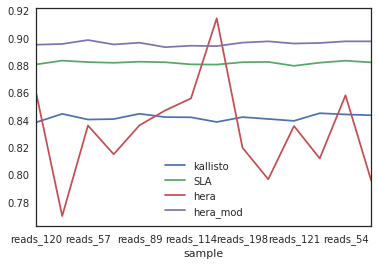

In [183]:
result_rsem_df.plot()

In [238]:
prefix = "/mnt/scratch1/bleed_through_human"
types_of = ["read_31415926"]
#types_of = ["read_11563" , "read_26368" , "read_9636"]
files_rsem = {}
for t in types_of:
    fileinfo = {}
    fileinfo["truth"]= prefix + "/" + t +"/" +"sim.sim.isoforms.results"
    fileinfo["SLA"] =  "/".join([prefix,t,"quant","salmon_out","quant.sf"])
    fileinfo["kallisto"] = "/".join([prefix,t,"quant","kallisto_out","abundance.tsv"])
    fileinfo["hera"] = "/".join([prefix,t,"quant","hera_out","abundance.tsv"])
    files_rsem[t] = fileinfo

In [239]:
result_rsem_df = pd.DataFrame(columns=['sample','kallisto', 'SLA','hera'])
for i,t in enumerate(types_of):
    df = mergeHeraKallisto(t,files_rsem)
    kal=df["count"].corr(df["NumReads_KAL"],method="spearman")
    sla=df["count"].corr(df["NumReads"],method="spearman")
    hera=df["count"].corr(df["NumReads_hera"],method="spearman")
    result_rsem_df.loc[i] = [t,kal,sla,hera]

In [240]:
result_rsem_df

,sample,kallisto,SLA,hera
0,read_31415926,0.749622,0.821377,0.822163


In [241]:
rd,non_zeros = relDiff('count','NumReads_hera',df)
print rd.abs().mean()
rd,non_zeros = relDiff('count','NumReads',df)
print rd.abs().mean()
rd,non_zeros = relDiff('count','NumReads_KAL',df)
print rd.abs().mean()

relDiff    0.029856
dtype: float64
relDiff    0.031383
dtype: float64
relDiff    0.050081
dtype: float64


In [244]:
rd,non_zeros = relDiff('count','NumReads_hera',df)
print rd.abs().mean()[0]
rd,non_zeros = relDiff('count','NumReads',df)
print rd.abs().mean()
rd,non_zeros = relDiff('count','NumReads_KAL',df)
print rd.abs().mean()

0.02985572183733916
relDiff    0.031383
dtype: float64
relDiff    0.050081
dtype: float64


In [210]:
prefix = "/mnt/scratch1/bleed_through_human"
types = ["bleed_through_200K"]
files = {}
for t in types:
    fileinfo = {}
    fileinfo["truth"]= "/".join([prefix,t,"rsem_sim","sim.sim.isoforms.results"])
    fileinfo["SLA"] =  "/".join([prefix,t,"quant","salmon_out","quant.sf"])
    fileinfo["kallisto"] = "/".join([prefix,t,"quant","kallisto_out","abundance.tsv"])
    #fileinfo["bowtie"] = "/".join([prefix,t,"quant","bowtie_out","quant.sf"])
    #fileinfo["hera"] = "/".join([prefix,t,"quant","hera_out","abundance.tsv"])
    #fileinfo["hera"] = "/".join([prefix,"hera_new","abundance.tsv"])
    fileinfo["hera"] = "/".join([prefix,"hera_new_2","abundance.tsv"])
    files[t] = fileinfo

In [211]:
df = mergeHeraKallisto("bleed_through_200K",files)

In [212]:
print("kallisto",df["count"].corr(df["NumReads_KAL"],method="spearman"))
print("SLA",df["count"].corr(df["NumReads"],method="spearman"))
#print("BowTie2",df_30["count"].corr(df_30["NumReads_BT"],method="spearman"))
print("hera",df["count"].corr(df["NumReads_hera"],method="spearman"))

('kallisto', 0.7450557220439691)
('SLA', 0.8198710974237589)
('hera', 0.8193086327038834)
